In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Load Libraries and set directories
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay,classification_report,roc_curve, auc
from sklearn.model_selection import cross_val_predict,RepeatedStratifiedKFold
from sklearn.calibration import calibration_curve
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder

In [3]:
import sys
import os

sys.path.append(os.path.expanduser('~/Documents/Apziva_projects'))
import feature_plots as fp

##Data Exploration

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

In [62]:
df = pd.read_csv("term-deposit-marketing-2020.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [63]:
df.age.min()

19

In [64]:
#sampling
#resamople to balance classes
#only on the train set
#probict_proba
df.y.value_counts()

y
no     37104
yes     2896
Name: count, dtype: int64

In [65]:
#One liners
df["default"] = df["default"].map({"yes": 1, "no": 0})
df["housing"] = df["housing"].map({"yes": 1, "no": 0})
df["loan"] = df["loan"].map({"yes": 1, "no": 0})
df["y"] = df["y"].map({"yes": 1, "no": 0})
df['age_log'] = np.log(df['age'] + 1)
# df['duration_log'] = np.log(df['duration'] + 1)
# df['job_combined'] = ['student_retired' if (x == 'retired')|(x == 'student') else x for x in df['job']]
# Dates
df['month'] = df["month"].map({'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12})
df['payday'] = df['day'].apply(lambda x: 1 if x in [28,30,31] else 0)
df = df[df['contact'] != 'unknown']
# df = df[(df['job'] != 'unknown') & (df['education'] != 'unknown')]

In [ ]:
2792/40000

0.0698

## Feature Engineering and Data Cleaning

### Numeric to Categorical Conversion


In [29]:

bins = [-np.inf, 0, np.quantile(df['balance'], 0.25), np.quantile(df['balance'], 0.75), np.quantile(df['balance'], 0.90), np.inf]
labels = ['Neg', 'Low', 'Med', 'High','Very_High']

df['balance_cat'] = pd.cut(df['balance'], bins=bins, labels=labels)

df['balance_cat'].value_counts()


balance_cat
Med          20000
Neg           6940
High          5995
Very_High     4000
Low           3065
Name: count, dtype: int64

In [30]:
df["age_binned"] = pd.cut(
    df["age"],
    bins=[19, 25, 35, 45, 55, np.inf],
    labels=["19-25", "26-35", "36-45", "46-55", "56+"],
    right=True,  
)

### Feature Visualization

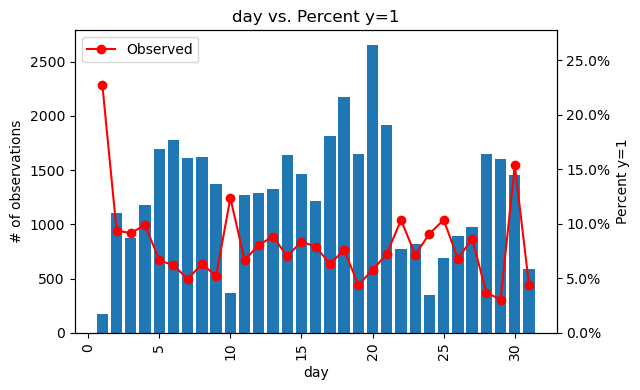

In [31]:
fp.plot_feature_vs_y(df,feature = 'day', y_col='y', dtype= 'cat', levels = list(range(1,32)), show_boxplot=False)

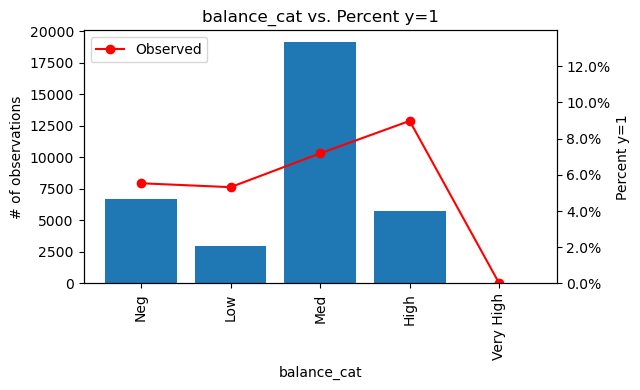

In [ ]:
fp.plot_feature_vs_y(df, feature = 'balance_cat',y_col='y', dtype= 'cat', levels = ['Neg', 'Low', 'Med', 'High', 'Very High'], show_boxplot=False)

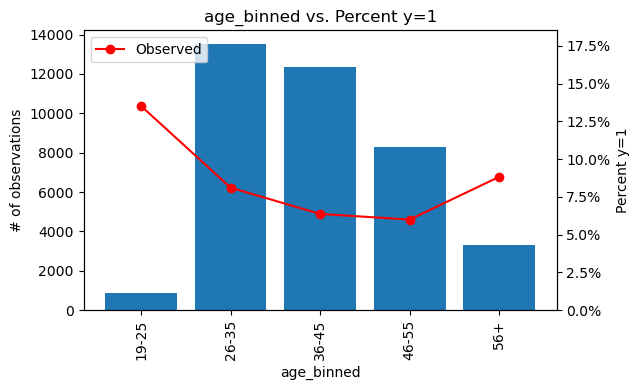

In [ ]:
fp.plot_feature_vs_y(df, feature = 'age_binned',y_col='y', dtype= 'cat', levels = [ "19-25", "26-35", "36-45", "46-55", "56+"], show_boxplot=False)

/var/folders/4l/s81p4w090kx1p7r6kb_bznjm0000gn/T/ipykernel_9592/2590238381.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["age_binned_combined"] = df["age_binned"].replace({


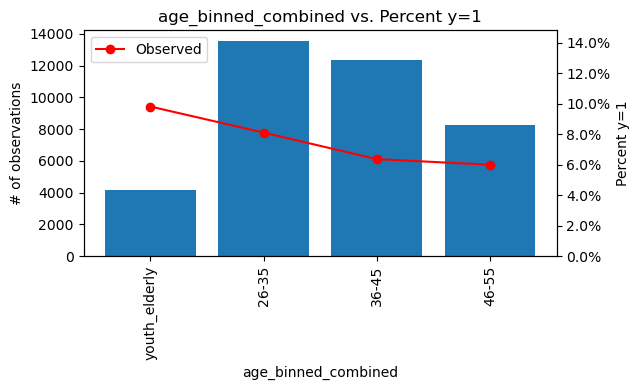

In [ ]:
df["age_binned_combined"] = df["age_binned"].replace({
    "19-25": "youth_elderly", 
    "56+": "youth_elderly"
})
fp.plot_feature_vs_y(df, feature = 'age_binned_combined',y_col='y', dtype= 'cat', levels = [ "youth_elderly", "26-35", "36-45", "46-55"], show_boxplot=False)

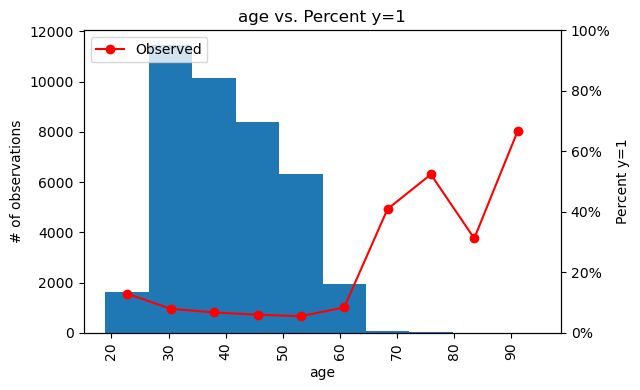

In [ ]:
fp.plot_feature_vs_y(df, feature = 'age',y_col='y', dtype= 'quant', show_boxplot=False, n_bins= 10, bin_method="cut")

In [ ]:
#Check to ensure the values make sense
#Remove outliers by variable instead of general sweep
#Only remove outliers in training data

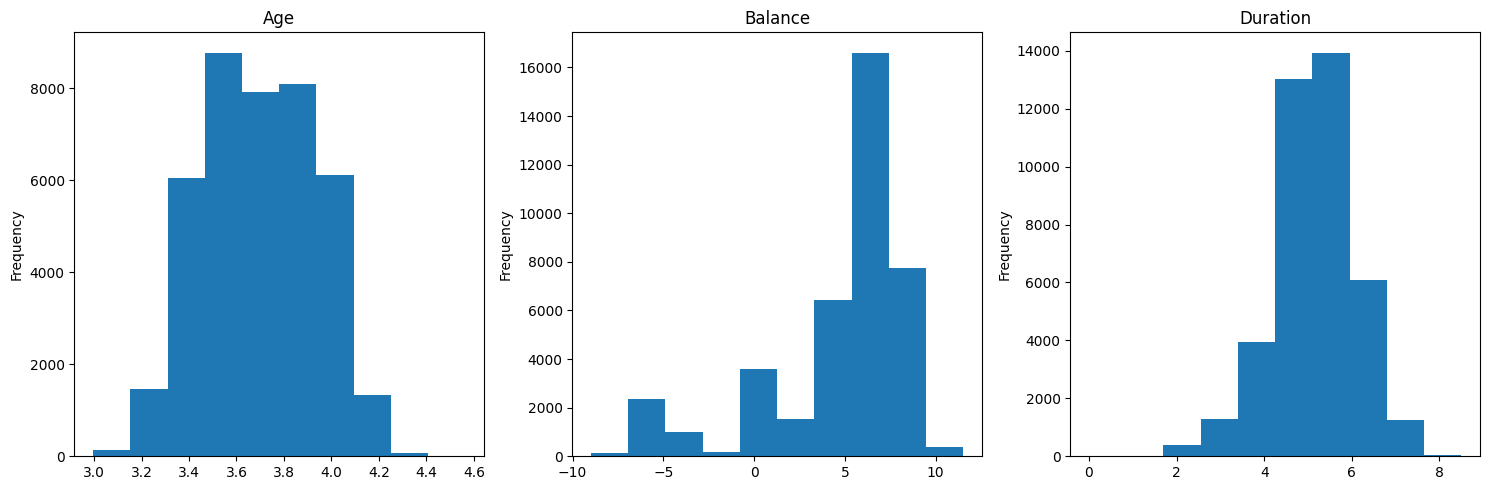

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
# Flatten axes for easy indexing
axes = axes.flatten()
df.age_log.plot.hist(ax=axes[0], title="Age")
df.balance_log.plot.hist(ax=axes[1], title="Balance")
df.duration_log.plot.hist(ax=axes[2], title="Duration")
plt.tight_layout()
plt.show()

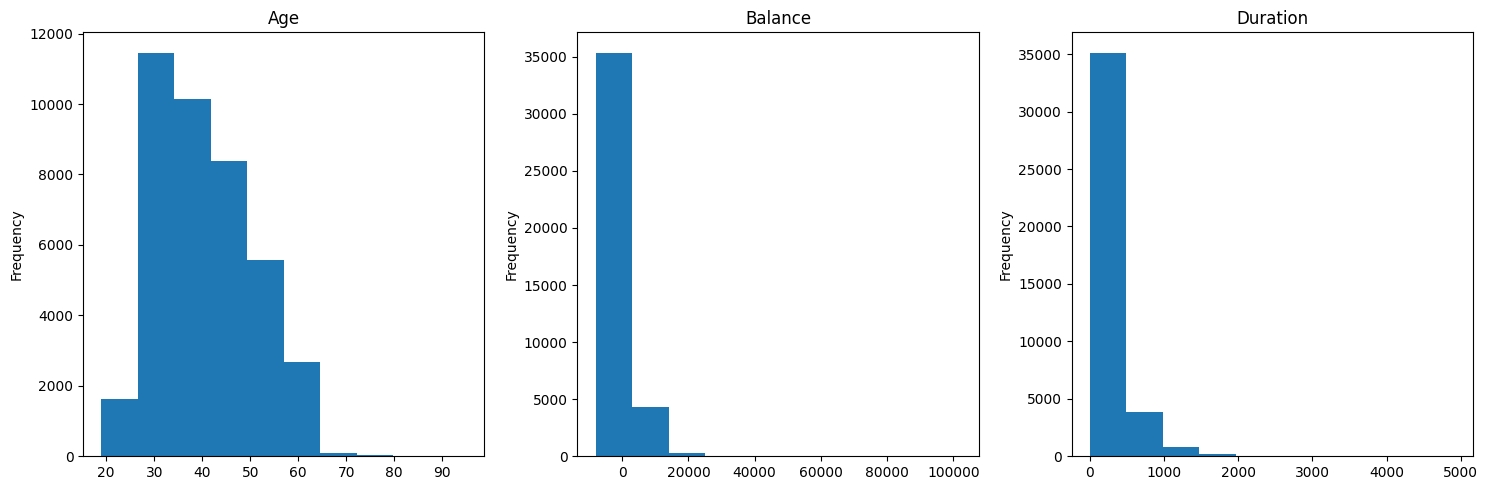

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
# Flatten axes for easy indexing
axes = axes.flatten()
df.age.plot.hist(ax=axes[0], title="Age")
df.balance.plot.hist(ax=axes[1], title="Balance")
df.duration.plot.hist(ax=axes[2], title="Duration")
plt.tight_layout()
plt.show()

In [ ]:
# Make a grid of 2 rows × 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Flatten axes for easy indexing
axes = axes.flatten()

df.job.value_counts().plot.barh(ax=axes[0], title="Job")
df.marital.value_counts().plot.barh(ax=axes[1], title="Marital")
df.education.value_counts().plot.barh(ax=axes[2], title="Education")
df.contact.value_counts().plot.barh(ax=axes[3], title="Contact")
df.month.value_counts().plot.barh(ax=axes[4], title="Month")

# Hide the unused subplot (6th slot)
axes[5].axis("off")

plt.tight_layout()
plt.show()

###Explore Variable relationships with Y

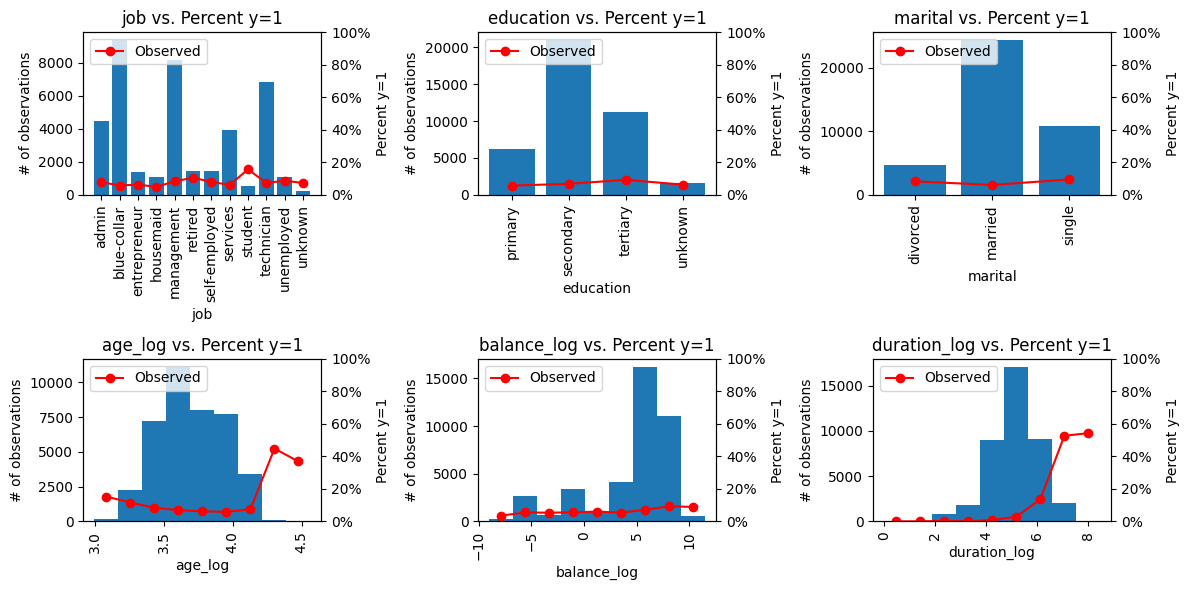

In [ ]:
# Grid of many features
fp.plot_features_vs_y_grid(
    df, ["job","education","marital","age_log","balance_log","duration_log"],
    y_col="y",
    dtype={"job":"cat","education":"cat","marital":"cat","age_log":"quant","balance_log":"quant","duration_log":"quant"},
    n_bins=9, cols=3, bin_method = "cut"
)


## Model

**Data_split**

In [67]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y',
       'age_log', 'payday'],
      dtype='object')

In [68]:
y = df["y"]
# X = df.drop(columns=["y", "age_log", "balance", "duration_log","job","age_binned"])
X = df.drop(columns=["y","age"])
X.sample(15)


,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,age_log,payday
15286,entrepreneur,divorced,secondary,0,2998,1,0,cellular,18,7,623,3,3.713572,0
24101,admin,married,secondary,0,352,0,0,telephone,28,10,60,1,3.465736,1
29825,management,married,secondary,0,438,0,0,cellular,4,2,42,5,3.891820,0
23848,management,single,tertiary,0,109,0,0,cellular,29,8,159,2,3.688879,0
38486,technician,married,primary,0,-50,1,0,cellular,15,5,129,2,3.970292,0
20872,housemaid,married,primary,0,19,0,0,cellular,13,8,111,2,4.043051,0
37991,blue-collar,married,primary,0,1,1,1,cellular,14,5,649,2,3.784190,0
22714,retired,married,tertiary,0,0,0,0,cellular,25,8,101,3,4.110874,0
15378,admin,divorced,primary,0,505,0,1,cellular,18,7,119,4,3.850148,0
37367,blue-collar,married,secondary,0,328,1,0,cellular,13,5,484,3,3.583519,0


In [69]:
#Preprocessing Data
# cat = ["job_combined","education","marital","contact","balance_cat"]
cat = ["job", "education","marital","contact"]
#OneHot Encoding
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(
    [('one_hot', OneHotEncoder(dtype='float'), cat)],
    remainder='passthrough', verbose_feature_names_out=False)

X_hot_encode = ct.fit_transform(X)
hot_encode_names = ct.get_feature_names_out().tolist()
X_hot_encode = pd.DataFrame(X_hot_encode, columns=hot_encode_names)


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_hot_encode, y, test_size=0.20, random_state=42)


In [71]:
# Recombine training data
train = pd.DataFrame(X_train, columns=hot_encode_names)
train['y'] = y_train.values
train
# Separate majority and minority classes
majority = train[train.y == 0]
minority = train[train.y == 1]

# Upsample minority to match majority size
minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=len(majority),
    random_state=42
)

# Combine back together
train_upsampled = pd.concat([majority, minority_upsampled])

# Split X and y again
X_train_balanced = train_upsampled.drop("y", axis=1)
y_train_balanced = train_upsampled["y"]

print("Before upsampling:\n", y_train.value_counts())
print("\nAfter upsampling:\n", y_train_balanced.value_counts())

Before upsampling:
 y
0    19882
1     1906
Name: count, dtype: int64

After upsampling:
 y
0    19882
1    19882
Name: count, dtype: int64


## Logistic Regression

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score

lr = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    C=1,
    l1_ratio=0.5,
    max_iter=1000,
    class_weight="balanced"
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

thresholds = np.linspace(0, 1, 101)
f1_scores = np.zeros_like(thresholds, dtype=float)

X_hot_encode = pd.DataFrame(X_hot_encode, columns=hot_encode_names)

for train_idx, val_idx in cv.split(X_hot_encode, y):
    lr.fit(X_hot_encode.iloc[train_idx], y.iloc[train_idx])
    probs = lr.predict_proba(X_hot_encode.iloc[val_idx])[:, 1]
    for i, t in enumerate(thresholds):
        preds = (probs >= t).astype(int)
        f1_scores[i] += f1_score(y.iloc[val_idx], preds)

f1_scores /= cv.get_n_splits()

best_t = thresholds[np.argmax(f1_scores)]
print("Best threshold:", best_t)

# Fit once on full training set
lr.fit(X_hot_encode, y)
probs = lr.predict_proba(X_hot_encode)[:, 1]

fpr, tpr, roc_thres = roc_curve(y, probs)
precision, recall, pr_thres = precision_recall_curve(y, probs)

plt.figure()
plt.plot(fpr, tpr, label="ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.figure()
plt.plot(recall, precision, label="PR")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()

plt.figure()
plt.plot(thresholds, f1_scores, label="F1 vs Threshold")
plt.axvline(best_t, color="r", linestyle="--", label=f"Best={best_t:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold Selection")
plt.legend()
plt.show()


KeyboardInterrupt: 

In [ ]:
# Linear Regresssion - original
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
lr = LogisticRegression(penalty='elasticnet', solver= 'saga', C=1, l1_ratio=0.5, max_iter=5000,class_weight="balanced")
lr.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'saga'
,max_iter,5000
,multi_class,'deprecated'


In [ ]:
y_prob_test = lr.predict_proba(X_test)[:, 1]
y_prob_train = lr.predict_proba(X_train)[:, 1]
threshold = 0.73
y_pred_test = (y_prob_test >= threshold).astype(int)
y_pred_train = (y_prob_train >= threshold).astype(int)
print("Train Metrics")
print(classification_report(y_train, y_pred_train))
print("Test Metrics")
print(classification_report(y_test, y_pred_test))

Train Metrics
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     29680
           1       0.43      0.52      0.47      2320

    accuracy                           0.91     32000
   macro avg       0.70      0.73      0.71     32000
weighted avg       0.92      0.91      0.92     32000

Test Metrics
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7424
           1       0.42      0.54      0.47       576

    accuracy                           0.91      8000
   macro avg       0.69      0.74      0.71      8000
weighted avg       0.92      0.91      0.92      8000



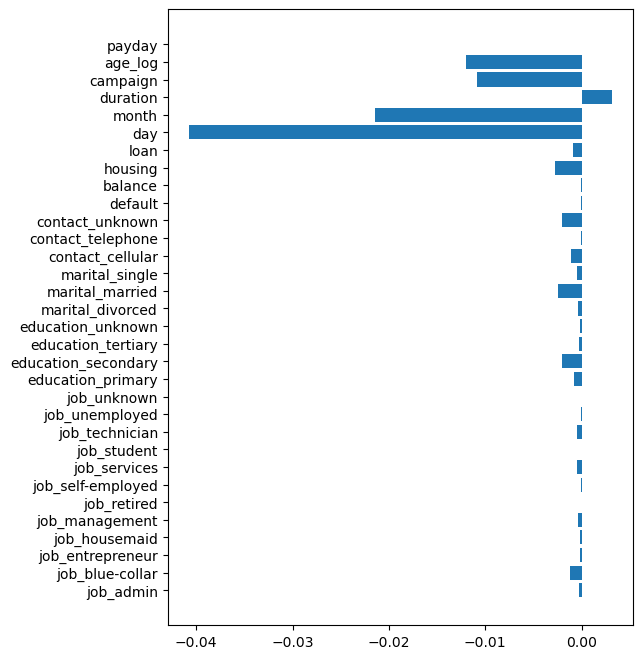

In [ ]:
plt.figure(figsize=(6, 8))
plt.barh(hot_encode_names, lr.coef_[0])
plt.show()

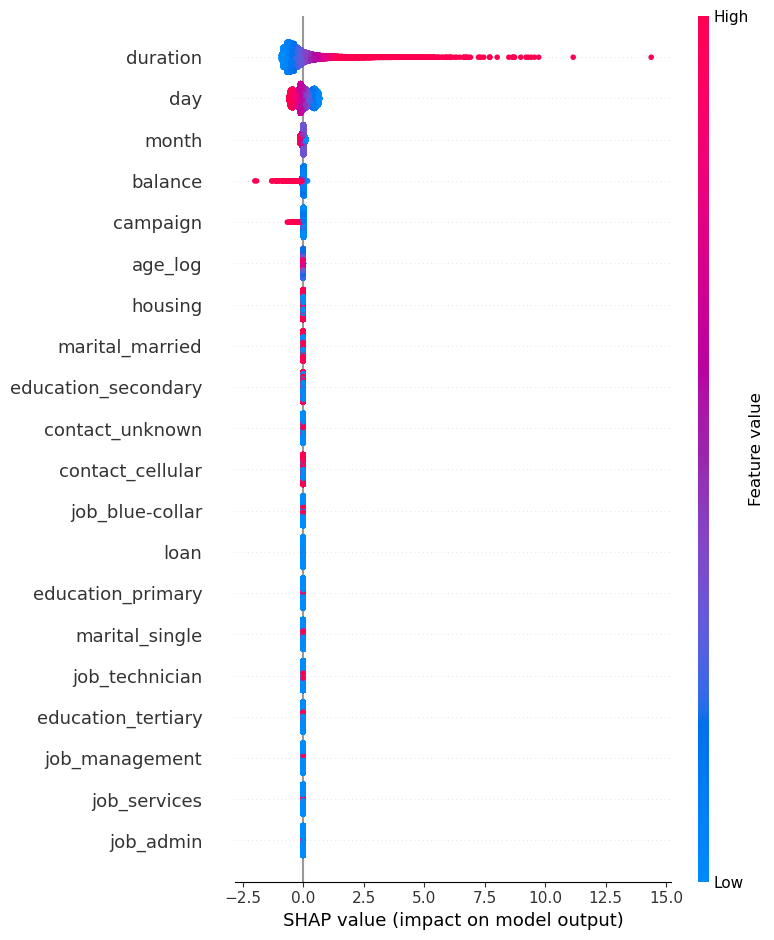

In [ ]:
import shap

# Assumes X_hot_encode is a DataFrame
explainer = shap.LinearExplainer(lr, X_hot_encode, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_hot_encode)

shap.summary_plot(shap_values, X_hot_encode)



In [ ]:
# Stratified sampling: equal from each class
n_per_class = 100
idx_0 = y[y == 0].sample(n=n_per_class, random_state=42).index
idx_1 = y[y == 1].sample(n=n_per_class, random_state=42).index

X_sample = X_hot_encode.loc[idx_0.union(idx_1)]
y_sample = y.loc[idx_0.union(idx_1)]

In [ ]:
explainer = shap.KernelExplainer(lr.predict_proba, shap.sample(X_hot_encode, 100))
shap_values = explainer.shap_values(X_sample) 
explanation = explainer(X_sample)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
shap.plots.beeswarm(explanation)

#Try different models as well

## XGBoost

In [72]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import make_scorer, average_precision_score

model = XGBClassifier(
    objective="binary:logistic",
    max_delta_step=1,
    scale_pos_weight = 12.6,
    eval_metric="logloss"
)
pr_auc_scorer = make_scorer(average_precision_score,  response_method="predict_proba", pos_label=1)
param_dist = {
    "learning_rate": np.logspace(-3, 0, 20),     # 0.001 to 1
    "max_depth": [3, 4, 5, 6, 7, 8],             # tree depth
    "min_child_weight": [1, 5, 10],              # minimum sum of weights
    "subsample": [0.6, 0.8, 1.0],                # row sampling
    "colsample_bytree": [0.6, 0.8, 1.0],         # feature sampling
    "gamma": np.linspace(0, 5, 10),
    "n_estimators": np.arange(200, 2000, 200)
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

halving_search = HalvingRandomSearchCV(
    estimator=model,
    param_distributions=param_dist,
    factor=3,              # resource multiplier each round
    random_state=1,
    cv=cv,
    scoring= pr_auc_scorer,
    n_jobs=-1,
    verbose=1
)

halving_result = halving_search.fit(X_hot_encode, y)

print("Best: %f using %s" % (halving_result.best_score_, halving_result.best_params_))


n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 40
max_resources_: 27235
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 680
n_resources: 40
Fitting 10 folds for each of 680 candidates, totalling 6800 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1046: Us

KeyboardInterrupt: 

Best threshold: 0.67


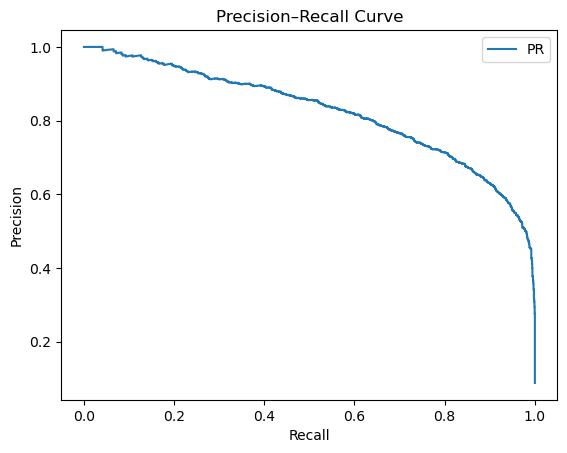

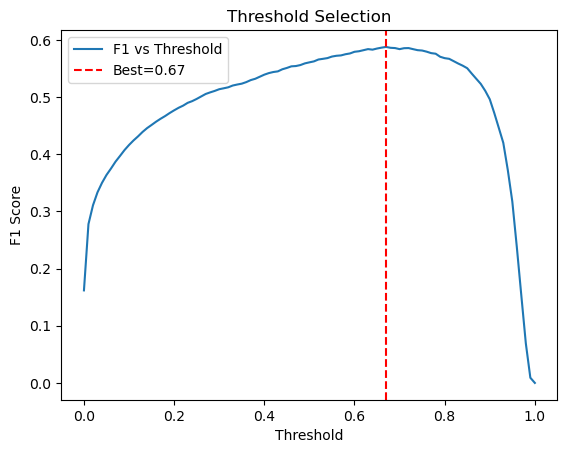

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score

model = XGBClassifier(learning_rate= 0.2, objective='binary:logistic',gamma = 0.26,max_delta_step=1, scale_pos_weight=12.6)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

thresholds = np.linspace(0, 1, 101)
f1_scores = np.zeros_like(thresholds, dtype=float)

X_hot_encode = pd.DataFrame(X_hot_encode, columns=hot_encode_names)

for train_idx, val_idx in cv.split(X_hot_encode, y):
    model.fit(X_hot_encode.iloc[train_idx], y.iloc[train_idx])
    probs = model.predict_proba(X_hot_encode.iloc[val_idx])[:, 1]
    for i, t in enumerate(thresholds):
        preds = (probs >= t).astype(int)
        f1_scores[i] += f1_score(y.iloc[val_idx], preds)

f1_scores /= cv.get_n_splits()

best_t = thresholds[np.argmax(f1_scores)]
print("Best threshold:", best_t)

# Fit once on full training set
model.fit(X_hot_encode, y)
probs = model.predict_proba(X_hot_encode)[:, 1]

fpr, tpr, roc_thres = roc_curve(y, probs)
precision, recall, pr_thres = precision_recall_curve(y, probs)

plt.figure()
plt.plot(recall, precision, label="PR")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()

plt.figure()
plt.plot(thresholds, f1_scores, label="F1 vs Threshold")
plt.axvline(best_t, color="r", linestyle="--", label=f"Best={best_t:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold Selection")
plt.legend()
plt.show()


In [ ]:
# create model instance
#n_estimators=1000, max_depth=5, learning_rate=.1, objective='binary:logistic',
#Best: 0.558159 using {'scale_pos_weight': 12.6, 'n_estimators': 1920, 'learning_rate': 0.19999999999999998, 'gamma': 0.2631578947368421}
model = XGBClassifier(learning_rate= 0.2, objective='binary:logistic',gamma = 0.26,max_delta_step=1, scale_pos_weight=12.6)
# model = XGBClassifier(learning_rate= 0.2, objective='binary:logistic',gamma = .26, n_estimators = 1920, num_parallel_tree=5, scale_pos_weight=12.6, max_delta_step=1)
# model = XGBClassifier(learning_rate= 0.2, objective='binary:logistic',gamma = 5, n_estimators = 1400, num_parallel_tree=5, scale_pos_weight=12.6, max_depth=5, min_child_weight=10,max_delta_step=1)   
# fit model
# model.fit(X_train, y_train)
model.fit(X_train, y_train)
# make predictions
# Ideal threshold = 0.77 but higher f1 at 0.7
threshold = 0.67
y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob_test = model.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= threshold).astype(int)
y_pred_train = (y_prob_train >= threshold).astype(int)

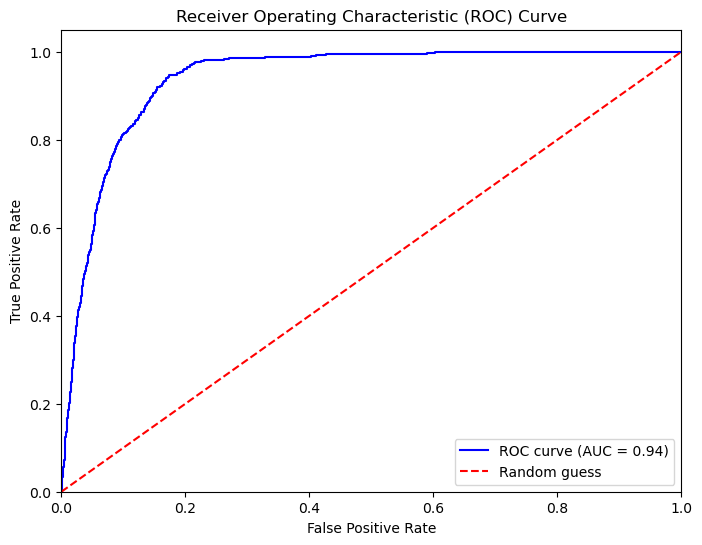

In [85]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC for test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# print("Train Metrics")
# print(classification_report(y_train, y_pred_train))
print("Test Metrics")
print(classification_report(y_test, y_pred_test))
#f1 = .57
#f1 = .47
#f1 = .46
#f1_balanced = .51
#f1_unbalanced = .60

Test Metrics
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      4954
           1       0.34      0.95      0.51       493

    accuracy                           0.83      5447
   macro avg       0.67      0.88      0.70      5447
weighted avg       0.93      0.83      0.86      5447



Test


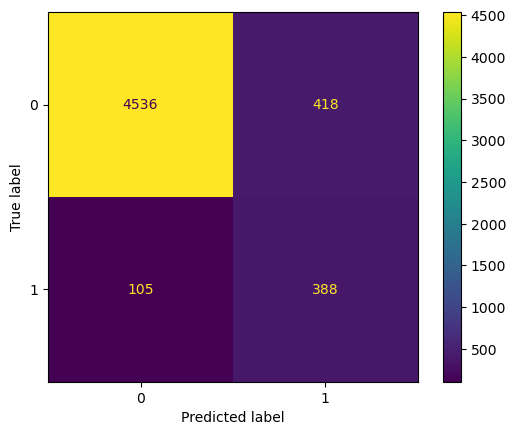

In [77]:
print("Test")
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model.classes_)
disp_test.plot()
plt.show()

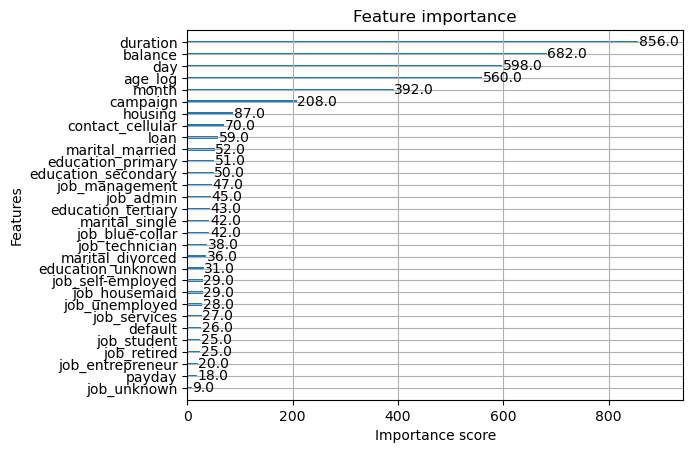

In [78]:
#AUC/ROC
#Predicted vs. Observed
model.get_booster().feature_names = hot_encode_names
plot_importance(model.get_booster())
plt.show()

In [79]:
import shap
# X_hot_encode = pd.DataFrame(X_hot_encode, columns=hot_encode_names)
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.initjs()



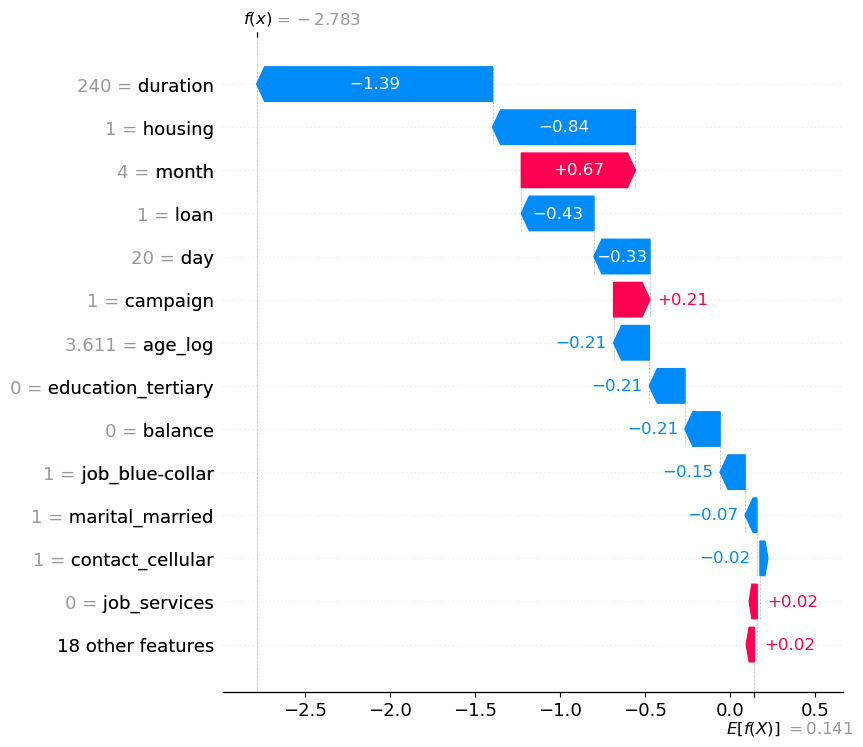

In [80]:
shap.plots.waterfall(shap_values[0], max_display=14)


In [45]:
ax = shap.plots.waterfall(shap_values[0], max_display=14, show=False)
fig = ax.figure
fig.savefig("waterfall_plot.png", dpi=300, bbox_inches="tight")
plt.close(fig)

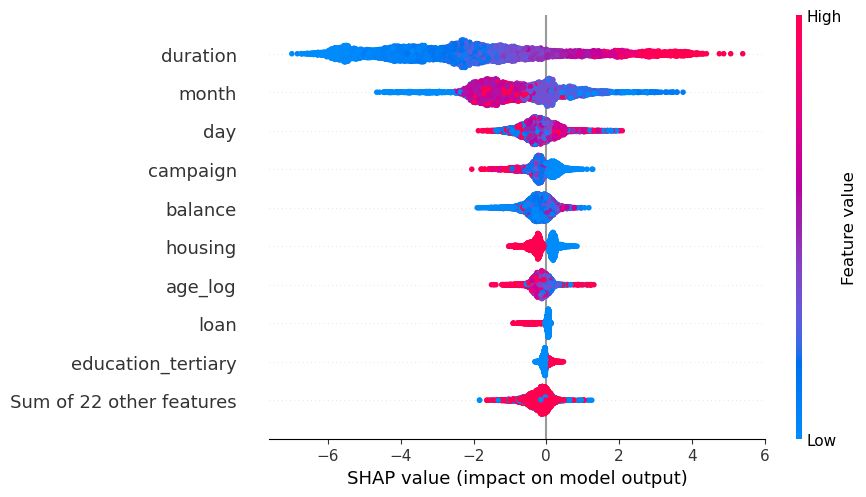

In [81]:
shap.plots.beeswarm(shap_values)

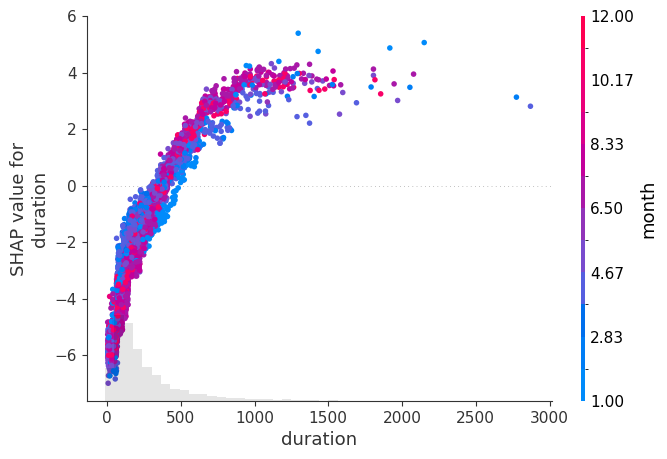

In [82]:
shap.plots.scatter(
    shap_values[:, "duration"],     
    color=shap_values               
)

plt.show()

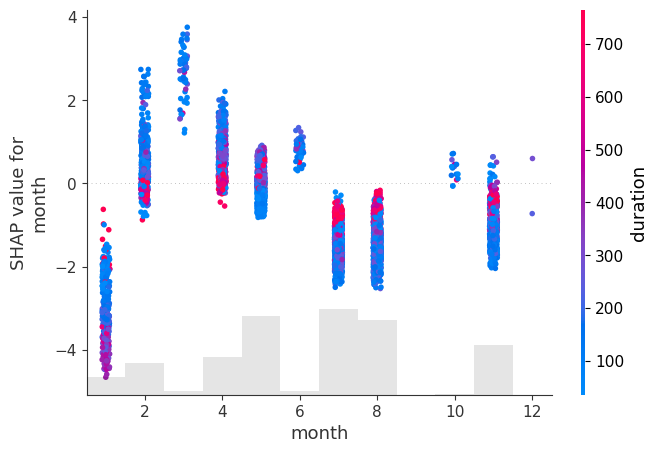

In [83]:
shap.plots.scatter(
    shap_values[:, "month"],     
    color=shap_values               
)

plt.show()

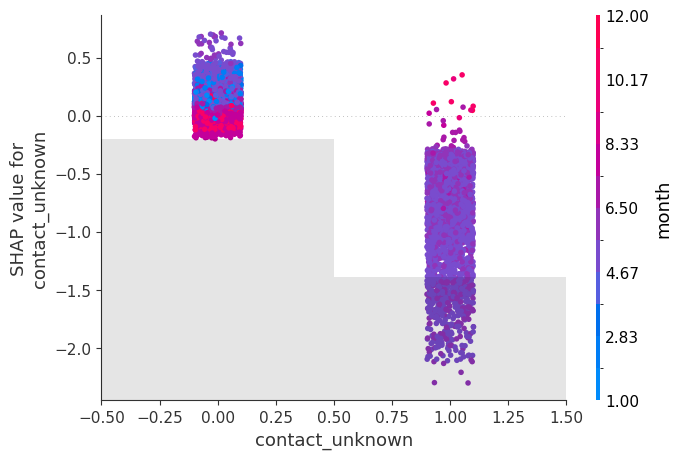

In [ ]:
shap.plots.scatter(
    shap_values[:, "contact_unknown"],     
    color=shap_values               
)

plt.show()

### Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(oob_score = True)
rf.fit(X_train_balanced, y_train_balanced)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [49]:
y_pred_test = rf.predict(X_test)
print("Test Metrics")
print(classification_report(y_test, y_pred_test))

Test Metrics
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      7424
           1       0.55      0.38      0.45       576

    accuracy                           0.93      8000
   macro avg       0.75      0.68      0.71      8000
weighted avg       0.92      0.93      0.93      8000



In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
grid_search.fit(X_train_balanced, y_train_balanced)

print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)

KeyboardInterrupt: 